In [68]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split

from managev_app.Research.ConsumptionEstimation.DataProcessing.lookup_tables import (
    ConsumptionModelLookup,
)
from managev_app.Research.ConsumptionEstimation.ExploratoryAnalysis.exporatory_analysis import (
    plot_exploratory_analysis,
)
from managev_app.Research.DataInteractor.data_fetcher import DataFetcher
from managev_app.Research.Route_segmentation.segmentation import SegmentTypes


from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)


<Figure size 640x640 with 0 Axes>

<Figure size 640x640 with 0 Axes>

In [64]:
y_name = "consumption_per_km"

query = (
    "select * from operation o where vehicle_id in"
    " ('GHW284', 'GVQ446', 'EGZ112', 'EPQ666', 'GVQ514')"
    " and o.operative_state > 0"
    " and elevation is not null ORDER BY vehicle_id desc, o.timestamp asc ;"
)

fetcher = DataFetcher(
    name="defensa_renault", query=query, segment_type=SegmentTypes.consumption
)
segments = fetcher.get_segments()

# Remove outliers
# 2.5 standard deviations away a given observation is from the mean
for col in ["kms", "min_acc", y_name, "consumption"]:
    segments = segments[(np.abs(stats.zscore(segments[col])) < 2.5)]

segments


,mean_acc,prom_abs_acc,std_acc,max_acc,min_acc,skew_acc,mean_current,prom_abs_current,std_current,max_current,...,time,traffic_factor,user_name,vehicle_id,speed_ind,test_id,end_time,mass,end_odometer,slope_cat
2,0.013529,0.305294,0.467194,1.23,-0.99,0.691246,1.977647,6.891765,9.088886,22.34,...,123.0,1.824125,usuarios_eafit_vehiculo_2,GVQ514,1.124859,0,2021-11-03 17:43:59,1528.0,10512.00,"(0.0, 5.0]"
3,-0.051556,0.259556,0.491288,1.20,-2.16,-1.305442,2.678222,7.860889,14.067282,40.88,...,312.0,0.671277,usuarios_eafit_vehiculo_2,GVQ514,0.755477,0,2021-11-03 17:51:18,1528.0,10513.20,"(-5.0, 0.0]"
4,-0.050435,0.254783,0.377538,0.70,-1.06,-0.463009,3.822174,8.134348,11.241702,26.47,...,186.0,1.215190,usuarios_eafit_vehiculo_2,GVQ514,1.253282,0,2021-11-04 06:38:43,1528.0,10518.30,"(-5.0, 0.0]"
5,-0.162174,0.464783,1.053945,0.74,-4.87,-3.792463,7.636957,10.910870,16.806199,70.25,...,126.0,2.608908,usuarios_eafit_vehiculo_2,GVQ514,1.971900,0,2021-11-04 06:53:53,1528.0,10522.20,"(0.0, 5.0]"
7,0.285000,0.360000,0.319257,0.62,-0.15,-0.224952,59.757500,59.757500,29.830952,88.81,...,15.0,42.633628,usuarios_eafit_vehiculo_2,GVQ514,0.905660,0,2021-11-04 12:05:05,1528.0,10528.20,"(-5.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894,-0.111429,0.220000,0.251364,0.21,-0.57,-0.490539,0.000000,0.000000,0.000000,0.00,...,65.0,7.090708,usuarios_eafit_vehiculo_2,EGZ112,0.885269,0,2021-08-26 19:29:51,1528.0,7214.07,"(-5.0, 0.0]"
1895,-0.009375,0.245625,0.329952,0.59,-0.68,-0.353075,0.000000,0.000000,0.000000,0.00,...,103.0,3.435709,usuarios_eafit_vehiculo_2,EGZ112,1.190746,0,2021-08-26 19:34:53,1528.0,7217.01,"(-10.0, -5.0]"
1896,-0.003490,0.021449,0.121904,1.17,-1.42,-2.002092,1.044878,1.281286,8.494914,129.47,...,28672.0,0.158168,usuarios_eafit_vehiculo_2,EGZ112,0.632911,0,2021-08-27 16:04:30,1528.0,7224.91,"(0.0, 5.0]"
1897,-0.009474,0.413684,0.617972,1.32,-1.71,-0.438166,-14.954211,22.515263,29.087842,30.50,...,124.0,1.072043,usuarios_eafit_vehiculo_2,EGZ112,1.150307,0,2021-08-27 16:29:57,1528.0,7228.34,"(-5.0, 0.0]"


energy_rec           -0.251851
min_speed            -0.154395
prom_abs_speed       -0.151750
mean_speed           -0.151750
traffic_factor       -0.139819
min_acc              -0.086451
skew_acc             -0.055571
fin_cap              -0.050711
mean_acc             -0.049252
mean_soc             -0.043886
nominal_speed        -0.032133
ini_cap              -0.031932
max_speed            -0.022333
mass                 -0.015760
batt_temp            -0.008497
end_odometer         -0.001889
prom_abs_acc          0.009211
energy                0.015789
std_acc               0.022831
speed_ind             0.044938
max_acc               0.055006
kms                   0.060599
std_current           0.073578
time                  0.084391
std_speed             0.102748
skew_power            0.133161
skew_speed            0.138463
skew_current          0.155198
prom_abs_current      0.188626
std_power             0.197885
min_current           0.199323
min_power             0.211056
max_curr

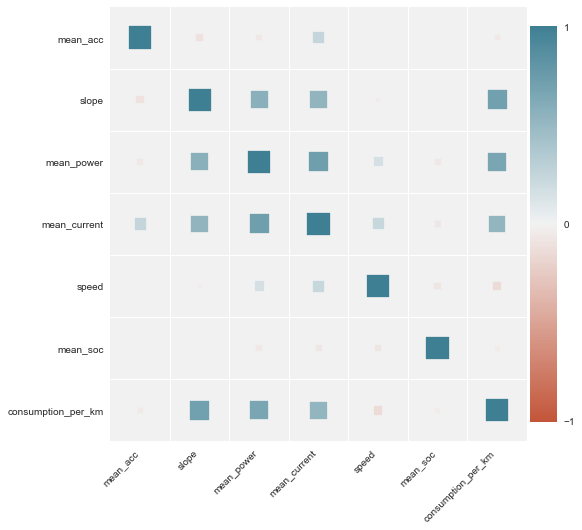

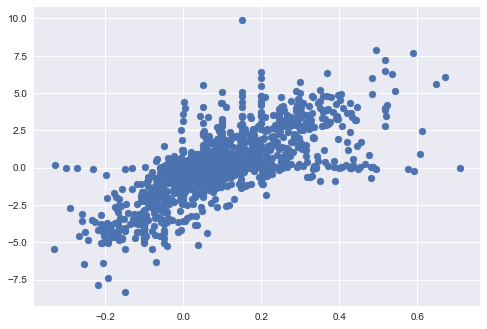

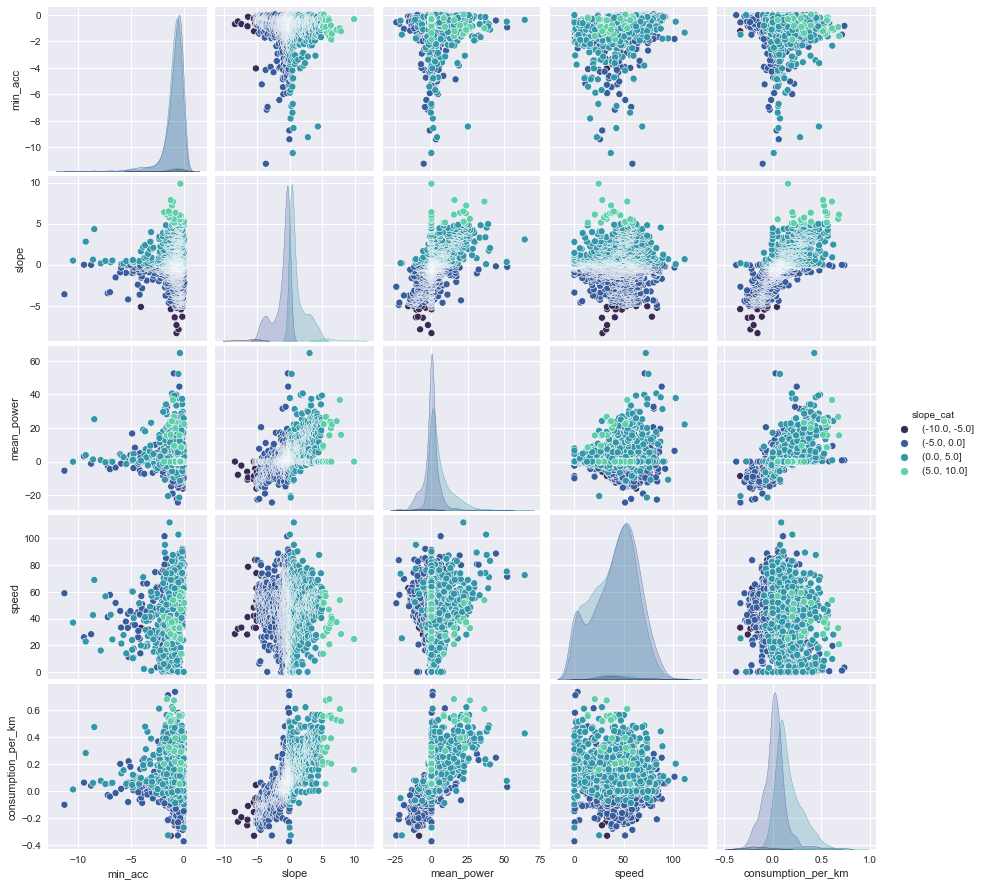

In [65]:
# Exploratory analysis
plot_exploratory_analysis(segments)




                     mean_power_usr  mean_speed     slope  consumption_per_km
mean_power_usr            1.000000   -0.056819  0.545194            0.417507
mean_speed               -0.056819    1.000000 -0.014220           -0.127320
slope                     0.545194   -0.014220  1.000000            0.684689
consumption_per_km        0.417507   -0.127320  0.684689            1.000000 


                                  OLS Regression Results                                
Dep. Variable:     consumption_per_km   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              6262.
Date:                Sun, 27 Feb 2022   Prob (F-statistic):                        0.00
Time:                        22:08:35   Log-Likelihood:                          847.71
No. Observations:                 953   AIC:                                     

<Figure size 1440x1440 with 0 Axes>

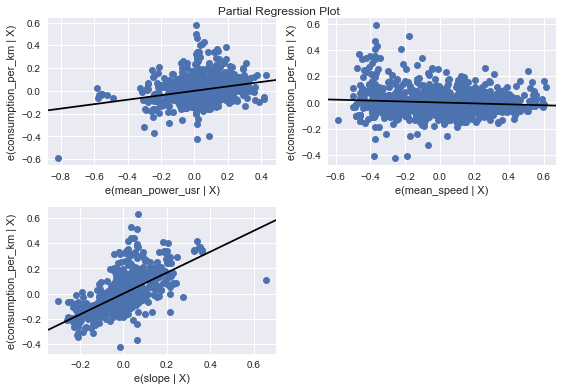

In [84]:
train, test = train_test_split(segments, test_size=0.2)


train, train_measure = train_test_split(train, test_size=0.3)
test, test_measure = train_test_split(test, test_size=0.4)

# Since power is not available on prediction, we need a lookup to get it
train_power_lookup = ConsumptionModelLookup(train_measure, build_lookups=True)
train = train_power_lookup.fill_with_lookups(train)


# ------------------- Model Training -------------------------------#
x_cols = ["mean_power_usr", "mean_speed", "slope"]
model_cols = ["mean_power_usr", "mean_speed", "slope", y_name]
selected_ft = train[model_cols]

print("\n", selected_ft.corr(), "\n")

# For linear regression
scaler = MinMaxScaler()
scaler.fit(train[model_cols])

train_scaled = pd.DataFrame(scaler.transform(train[model_cols]), columns=model_cols)

formula = "consumption_per_km ~ mean_power_usr + mean_speed + slope -1"

lm_consumo = ols(formula=formula, data=train_scaled).fit()
print("\n", lm_consumo.summary(), "\n")

plt.figure(figsize=[20, 20])
fig = sm.graphics.plot_partregress_grid(lm_consumo)
plt.show()


#  ------------------------ Test the models ----------------------------------- #
test_power_lookup = ConsumptionModelLookup(test_measure, build_lookups=True)
test = test_power_lookup.fill_with_lookups(test)

test_scaled = pd.DataFrame(scaler.transform(test[model_cols]), columns=model_cols)

y_test = test_scaled[y_name]

predictions = lm_consumo.predict(test_scaled)


In [112]:
scaler = MinMaxScaler()
scaler.fit(train[model_cols])
dump(scaler, open("MachineLearningModels/scaler.pkl", "wb"))

In [113]:
x_scaler = MinMaxScaler()
x_scaler.fit(train[x_cols])
dump(x_scaler, open('MachineLearningModels/x_scaler.pkl', 'wb'))

In [114]:
dump(lm_consumo, open('MachineLearningModels/linear_model.pkl', 'wb'))

# Model evaluation function

In [85]:
def model_evaluation(y_test, predictions):
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print("\n", "RMSE =", rmse)

    rmspe = (np.sqrt(np.mean(np.square((y_test - predictions) / y_test)))) * 100
    print("RMSPE =", rmspe)

    rme = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    print("RME =", rme)

    print("R2 =", r2_score(y_test, predictions))
    print("max error=", max(abs(y_test - predictions)), "\n")
    plt.figure()
    plt.scatter(x=y_test, y=predictions)
    plt.title("title")
    plt.xlabel("Real")
    plt.ylabel("Predicted")
    plt.show()


# Sklearn linear model


 RMSE = 0.09092028442039446
RMSPE = 21.927183076930923
RME = 15.683593004591891
R2 = 0.5857343330012155
max error= 0.32494461126846946 



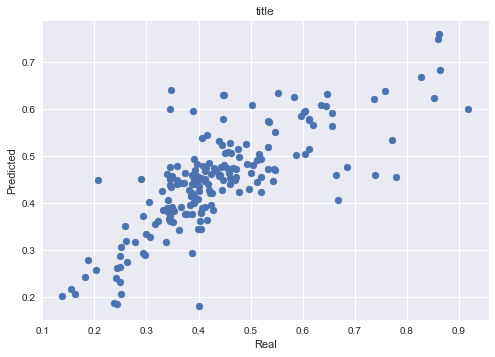

In [115]:
X = train_scaled[x_cols].values
y = train_scaled['consumption_per_km'].values

from sklearn import linear_model

linear_regr = linear_model.LinearRegression(n_jobs=-1)

linear_regr.fit(X, y)
y_pred_linear = linear_regr.predict(test_scaled[x_cols].values)
model_evaluation(y_test, y_pred_linear)
dump(linear_regr, open('MachineLearningModels/linear_regr_sklearn.pkl', 'wb'))

# Random forest


 RMSE = 0.09378570466799668
RMSPE = 22.583706916053423
RME = 15.646425810893136
R2 = 0.5592110869832979
max error= 0.348595176265469 



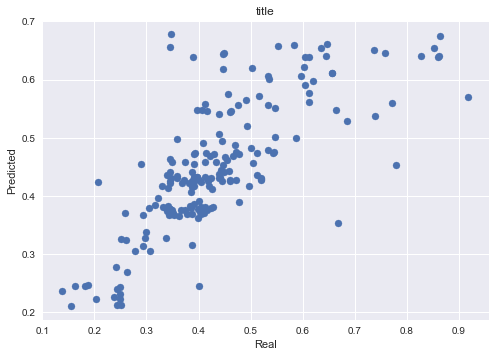

In [86]:
#  ---------------- Random Forest -----------------------#
X = train_scaled[x_cols].values
y = train_scaled[y_name].values

random_forest_regresor = RandomForestRegressor(
    n_estimators=149,
    max_depth=5,
    random_state=0,
    max_features="auto",
    criterion="mse",
    max_samples=0.219,
)

random_forest_regresor.fit(X, y)
y_pred = random_forest_regresor.predict(test_scaled[x_cols].values)

model_evaluation(y_test, y_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
print("Initialize Grid Search")
param_grid = { 
    'n_estimators': np.arange(5,70,5),
    'max_depth' : np.arange(2,20,2),
    'max_samples' : np.arange(0.1,0.9,0.1)
}
# create and fit a regression model, testing each parameter value

 

model = RandomForestRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

# Complexity curves

In [ ]:
from sklearn.metrics import mean_absolute_error

n_estimators = np.arange(1,200,1)
X_test = test_scaled[x_cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for estimators in n_estimators:
    reg = RandomForestRegressor(n_estimators = estimators, max_features='auto', max_depth=5, max_samples = 0.219,
                                criterion = 'mse', random_state = 0)
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(n_estimators, train_acc, 'b', label = 'Training RMSE')
plt.plot(n_estimators, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('number of estimators ', fontsize = 14)
# plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [ ]:
n_estimators[val_acc.index(min(val_acc))]


In [ ]:
depths = np.arange(1,20,1)
X_test = test_scaled[x_cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for depth in depths:
    reg = RandomForestRegressor(n_estimators = 48, max_features='auto', max_samples = 0.219,
                                max_depth=depth, criterion = 'mse', random_state = 0, n_jobs=-1)
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(depths, train_acc, 'b', label = 'Training RMSE')
plt.plot(depths, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Maximun tree depth', fontsize = 14)
# plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [ ]:
depths[val_acc.index(min(val_acc))]


In [ ]:
max_samples = np.arange(0.1,0.9,0.01)
X_test = test_scaled[x_cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for max_sample in max_samples:
    reg = RandomForestRegressor(n_estimators = 48, max_features='auto', max_samples = max_sample,
                                max_depth=5, criterion = 'mse', random_state = 0, n_jobs=-1)
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(max_samples, train_acc, 'b', label = 'Training RMSE')
plt.plot(max_samples, val_acc, 'r', label = 'Validation RMSE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Maximun samples', fontsize = 14)
# plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [ ]:
max_samples[val_acc.index(min(val_acc))]

In [ ]:
features=train_scaled.columns[[0, 1, 2, 3]]
importances = random_forest_regresor.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
#plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [116]:
dump(random_forest_regresor, open('MachineLearningModels/random_forest.pkl', 'wb'))

# XGBoost


 RMSE = 0.09492287077451166
RMSPE = 21.24861047875474
RME = 15.209611534951403
R2 = 0.548457015629097
max error= 0.4184206435514144 



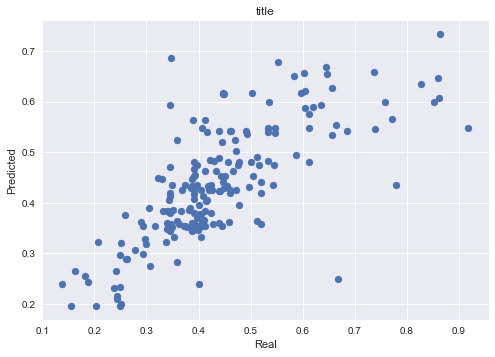

In [117]:
## 
import xgboost as xgb

data_dmatrix = xgb.DMatrix(data=X,label=y)

# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 0.5,
#                 max_depth = 10, n_estimators = 5)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7, learning_rate = 0.3,
                max_depth = 2, n_estimators = 41)


xg_reg.fit(X, y)

y_pred_xgb = xg_reg.predict(test_scaled[x_cols].values)
model_evaluation(y_test, y_pred_xgb)

# Save the model
dump(xg_reg, open('MachineLearningModels/xg_reg_model.pickle.dat', 'wb'))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
print("Initialize Grid Search")
param_distributions = { 
    'colsample_bytree' : np.arange(0.1, 1, 0.1),
    'learning_rate' : np.arange(0.1, 1, 0.1),
    'n_estimators': [2,3,4,5],
    'max_depth' : np.arange(10, 30, 2),
    'objective' :['reg:squarederror']
}
# create and fit a regression model, testing each parameter value

 
#     'n_estimators': np.arange(3,60,1),
#     'max_depth' : np.arange(3,40,1),
model = xgb.XGBRegressor()
grid = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_jobs=-1)
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

In [ ]:
n_estimators = np.arange(2,50,1)
X_test = test_scaled[cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for estimators in n_estimators:
    
    reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.75, learning_rate = 0.3,
                max_depth = 2, n_estimators = estimators, n_jobs=-1)

    
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(n_estimators, train_acc, 'b', label = 'Training RMSE')
plt.plot(n_estimators, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('number of estimators ', fontsize = 14)
#plt.title('Complexity curves for xgboost', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [ ]:
# El valor óptimo
n_estimators[val_acc.index(min(val_acc))]

In [ ]:
depths = np.arange(1,25,1)
X_test = test_scaled[cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for depth in depths:
    
    reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.75, learning_rate = 0.3,
                max_depth = depth, n_estimators = 19, n_jobs=-1) 
    
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(depths, train_acc, 'b', label = 'Training RMSE')
plt.plot(depths, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Maximun tree depth', fontsize = 14)
#plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [ ]:
depths[val_acc.index(min(val_acc))]

#### Percentage of columns samples by tree

In [ ]:
colsamples_bytree = np.arange(0.05,1,0.05)
X_test = test_scaled[cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for colsample_bytree in colsamples_bytree:
    
    reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = colsample_bytree, learning_rate = 0.3,
                max_depth = 2, n_estimators = 19, n_jobs=-1) 
    
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(colsamples_bytree, train_acc, 'b', label = 'Training RMSE')
plt.plot(colsamples_bytree, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Column samples by tree', fontsize = 14)
#plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [ ]:
colsamples_bytree[val_acc.index(min(val_acc))]

In [ ]:
learning_rates = np.arange(0.05,1,0.05)
X_test = test_scaled[cols].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for learning_rate in learning_rates:
    
    reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = learning_rate,
                max_depth = 2, n_estimators = 41, n_jobs=-1) 
    
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(learning_rates, train_acc, 'b', label = 'Training RMSE')
plt.plot(learning_rates, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Learning rates', fontsize = 14)
#plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [ ]:
learning_rates[val_acc.index(min(val_acc))]

In [ ]:
ax = xgb.plot_tree(xg_reg,num_trees=17)
fig = ax.figure
fig.set_size_inches(30, 35)
# fig = plot.get_figure()
# fig.savefig('test2png.png')

In [ ]:
ax = xgb.plot_importance(xg_reg)
fig = ax.figure
fig.set_size_inches(5, 5)

In [ ]:
params = {"objective":"reg:squarederror",'colsample_bytree': 1,'learning_rate': 0.1,
                'max_depth': 2, 'n_estimators': 24}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results

# Ann


 RMSE = 0.09859546651128935
RMSPE = 24.040137406053294
RME = 16.934718214875062
R2 = 0.5128404023948694
max error= 0.30947938365555766 



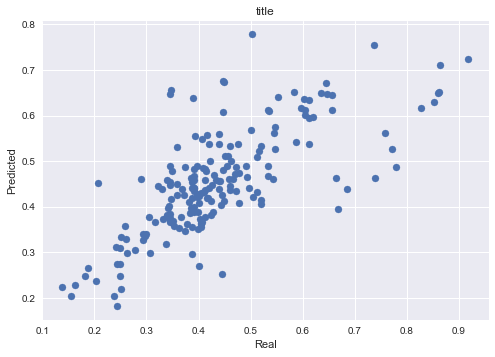

In [118]:
X = train_scaled[x_cols].values
y = train_scaled['consumption_per_km'].values

from sklearn.neural_network import MLPRegressor

ann_regr = MLPRegressor( activation='relu', alpha=0, hidden_layer_sizes= (50), max_iter=705000,
                        learning_rate='adaptive', warm_start=True, tol=1e-4, solver='lbfgs').fit(X, y)

#regr = MLPRegressor(random_state=1, max_iter=500, solver='lbfgs', activation='relu', alpha=0.002, hidden_layer_sizes=(150,)).fit(X, y)
y_ann=ann_regr.predict(test_scaled[x_cols].values)
ann_regr.score(test_scaled[x_cols].values, y_test)

model_evaluation(y_test, y_ann)
dump(ann_regr, open('MachineLearningModels/ann_regr.pkl', 'wb'))

In [ ]:
print("Initialize Grid Search")
param_grid = { 
    'solver':['lbfgs'],
     #arning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [(150,100), (150,)],
    'activation': ["logistic"],
    'max_iter':[10500],
    }


# create and fit a regression model, testing each parameter value


model = MLPRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

# Learning curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
 
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    #if ylim is not None:
        #axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    print('max train = ', np.mean(train_scores))
    print('max test = ', np.mean(test_scores))
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    print('Fitting time = ', np.mean(fit_times))

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    '''
    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, np.sort(test_scores_mean), 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    '''
    return plt


title = "Learning Curves (Neural Network)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = MLPRegressor(random_state=1, activation='tanh', alpha=0,
                         hidden_layer_sizes= (110 ), max_iter=70500, solver='lbfgs', learning_rate='invscaling')
plot_learning_curve(estimator, title, X, y, # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)
plt.show()

plt.figure()
title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestRegressor(n_estimators = 53, max_features='auto', max_samples = 0.1,
                                  max_depth=8, criterion = 'mse', random_state = 0, n_jobs=-1)
plot_learning_curve(estimator, title, X, y, # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show() 

plt.figure()
title = "Learning Curves (Ordinary least squares Linear Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = linear_model.LinearRegression(n_jobs=-1)
plot_learning_curve(estimator, title, X, y,  # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()


plt.figure()
title = "Learning Curves (XGBoost)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 0.15,
                             max_depth = 2, n_estimators = 18)

plot_learning_curve(estimator, title, X, y, # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()